### 1. Imports

In [7]:
# Standard Library

import numpy as np
import os
import time
from copy import deepcopy
from itertools import product
import json
from pathlib import Path

# Scientific Computing and Image Processing
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage import label, zoom, binary_dilation
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Image Analysis
from skimage import measure
from skimage.measure import marching_cubes

# Machine Learning
from sklearn.neighbors import NearestNeighbors

# === Part label configuration (example you provided) ===


part_colors = {
    "full_building":    [(253, 248, 96)],
    "chhatris":         [(1, 220, 5)],
    "plinth":           [(63, 138, 173)],
    "dome":             [(190, 0, 255)],
    "front_minarets":   [(0, 0, 255)],
    "back_minarets":    [(5, 223, 223)],
    "small_minarets":   [(255, 180, 80)],
    "main_door":        [(180, 140, 255)],
    "windows":          [(255, 120, 230)],
    "background":       [(216, 224, 251)]
}

part_colors_np = {k: np.array(v) for k,v in part_colors.items()}


### 2. Functions

In [23]:
# === LOADING & PREPROCESSING ===

def resize_image(img, scale=2):
    h, w = img.shape[:2]
    return cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_NEAREST)
    
def load_voxel_grid(npz_path):
    data = np.load(npz_path)
    voxel_grid = data["voxel_grid"]
    voxel_grid = np.flip(voxel_grid, axis=1)  # Flip Y for consistency
    return voxel_grid
   
def resize_voxel_grid(voxel_grid, scale=2):
    if voxel_grid.ndim == 4:
        zoom_factors = (1/scale, 1/scale, 1/scale, 1)
    else:
        zoom_factors = (1/scale, 1/scale, 1/scale)

    return zoom(voxel_grid, zoom=zoom_factors, order=0)  # order=0 for nearest neighbor (preserve labels/colors)

def voxel_grid_to_points(grid, axis='z', colormap='viridis', stride=2):
    W, H, D= grid.shape[:3]
    is_color = grid.ndim == 4 and grid.shape[3] == 3
    mask = np.any(grid, axis=-1) if is_color else grid != 0
    mask_ds = mask[::stride, ::stride, ::stride]
    xs, ys, zs = np.where(mask_ds)
    pts = np.stack([xs, ys, zs], axis=1).astype(np.float32) * stride

    if is_color:
        colors = grid[::stride, ::stride, ::stride][xs, ys, zs]
    else:
        vals = {'x': xs, 'y': ys, 'z': zs}[axis] / {'x': W - 1, 'y': H - 1, 'z': D - 1}[axis]
        colors = (plt.get_cmap(colormap)(vals)[:, :3] * 255).astype(np.uint8)

    return pts, colors, (W, H, D)
    
def extract_top_k_components(voxel_grid, color, k=4):
    mask = np.all(voxel_grid == color, axis=-1)
    labeled, _ = label(mask, structure=np.ones((3, 3, 3)))
    heights = [(i, np.ptp(np.argwhere(labeled == i)[:, 1])) for i in range(1, labeled.max() + 1)]
    top_ids = [idx for idx, _ in sorted(heights, key=lambda x: -x[1])[:k]]
    top_mask = np.isin(labeled, top_ids)
    filtered = voxel_grid.copy()
    filtered[mask & (~top_mask)] = 0
    return filtered

def compute_scene_center(voxel_grid):
    z, y, x = np.where(np.any(voxel_grid != 0, axis=-1))
    pts = np.stack([x, y, z], axis=1).astype(np.float32)
    return pts.mean(axis=0)

# === VISUALIZATION ===
def plot_voxel(points, colors=None):
    if colors is None:
        color_input = 'blue'
    else:
        colors = np.asarray(colors)
        if colors.ndim == 2 and colors.shape[1] == 3 and colors.max() > 1:
            colors = colors / 255
        color_input = colors

    fig = go.Figure(go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers', marker=dict(size=2, color=color_input, opacity=1)
    ))
    fig.update_layout(scene=dict(aspectmode='data'), title='3D Visualization')
    fig.show()

# === GEOMETRY & PROJECTION ===
def look_at_rotation(eye, target, up=np.array([0, 1, 0], dtype=np.float32)):
    z = target - eye
    z /= np.linalg.norm(z)
    if np.allclose(np.abs(np.dot(z, up)), 1.0):
        up = np.array([0, 0, 1], dtype=np.float32)
    x = np.cross(up, z)
    x /= np.linalg.norm(x)
    y = np.cross(z, x)
    return np.stack([x, y, z], axis=0)

def get_voxel_points_by_parts(grid, part_colors, part_names):
    all_colors = []
    for name in part_names:
        all_colors.extend(part_colors.get(name, []))
    mask = np.zeros(grid.shape[:3], dtype=bool)
    for color in all_colors:
        mask |= np.all(grid == color, axis=-1)
    z, y, x = np.where(mask)
    pts = np.stack([x, y, z], axis=1).astype(np.float32)
    colors = grid[z, y, x]
    return pts, colors

def project_colored_voxels(pts3d, colors, cam_pos, target, f, cx, cy, H, W):
    R = look_at_rotation(cam_pos, target)
    pts_cam = (pts3d - cam_pos) @ R.T
    X, Y, Z = pts_cam.T
    Z = np.where(Z < 1e-8, 1e-8, Z)
    u = (X / Z) * f + cx
    v = -(Y / Z) * f + cy
    ui = np.round(u).astype(int)
    vi = np.round(v).astype(int)
    valid = (ui >= 0) & (ui < W) & (vi >= 0) & (vi < H)

    proj_img = np.zeros((H, W, 3), dtype=np.uint8)
    proj_img[vi[valid], ui[valid]] = colors[valid]
    return proj_img


# === EVALUATION ===
def compute_partwise_iou(proj_mask, gt_mask, part_colors):
    flat_proj = proj_mask.reshape(-1, 3)
    flat_gt = gt_mask.reshape(-1, 3)
    iou_per_part = {}
    total_ious = []

    for part, bgr_list in part_colors.items():
        proj_part = np.any([np.all(flat_proj == bgr, axis=1) for bgr in bgr_list], axis=0)
        gt_part = np.any([np.all(flat_gt == bgr, axis=1) for bgr in bgr_list], axis=0)
        inter = np.logical_and(proj_part, gt_part).sum()
        union = np.logical_or(proj_part, gt_part).sum()
        iou = inter / union if union > 0 else 0.0
        iou_per_part[part] = iou
        total_ious.append(iou)

    return iou_per_part, np.mean(total_ious)

def mask_parts_from_image(image, part_colors, selected_parts):
    mask = np.zeros_like(image)
    for part in selected_parts:
        for color in part_colors[part]:
            match = np.all(image == color, axis=-1)
            mask[match] = color
    return mask

def visualize_voxel_projection_iou(
    voxel_grid,
    part_colors,
    image,
    cam_params,
    mode='part_on_whole',  # 'part_on_whole', 'part_on_part', 'whole_on_whole', 'whole_on_whole_color'
    save=False,
    save_root='visualisation'
):
    def compute_mask(image, color):
        return np.all(image == color, axis=-1)

    def compute_iou(gt_mask, prj_mask):
        inter = np.logical_and(gt_mask, prj_mask).sum()
        union = np.logical_or(gt_mask, prj_mask).sum()
        return inter / union if union > 0 else 0.0

    def outline_projection(base, gt_mask, prj_mask):
        combined_mask = np.logical_and(gt_mask, prj_mask)
        outline = binary_dilation(combined_mask) & ~combined_mask
        base[outline] = [255, 255, 0]  # yellow outline
        return base

    if save:
        save_dir = os.path.join(save_root, mode)
        os.makedirs(save_dir, exist_ok=True)

    H, W = image.shape[:2]
    combined_mask_gt = np.zeros((H, W), dtype=bool)
    combined_mask_prj = np.zeros((H, W), dtype=bool)
    combined_proj = np.zeros_like(image, dtype=np.float32)

    for part, colors in part_colors.items():
        # Project voxel part
        pts, col = get_voxel_points_by_parts(voxel_grid, part_colors, [part])
        proj_img = project_colored_voxels(
            pts, col,
            cam_params['cam_pos'], cam_params['target'],
            cam_params['f'], cam_params['cx'], cam_params['cy'],
            H, W
        )
        # proj_img = np.flipud(proj_img)


        # Generate binary masks
        mask_gt = np.any([compute_mask(image, c) for c in colors], axis=0)
        mask_prj = np.any([compute_mask(proj_img, c) for c in colors], axis=0)

        combined_mask_gt |= mask_gt
        combined_mask_prj |= mask_prj
        combined_proj += proj_img.astype(np.float32)

        if mode in ['part_on_whole', 'part_on_part']:
            iou = compute_iou(mask_gt, mask_prj)

            if mode == 'part_on_whole':
                vis = (0.7 * proj_img + 0.3 * image).astype(np.uint8)

            elif mode == 'part_on_part':
                vis = np.zeros_like(image)
                vis[mask_gt] = image[mask_gt]
                vis[mask_prj] = proj_img[mask_prj]

                overlap = mask_gt & mask_prj
                blended_overlap = np.clip((0.7 * proj_f + 0.3 * image_front) * 1.5, 0, 255)

                blended_overlap = np.clip((0.7 * proj_img + 0.3 * image) * 1.5, 0, 255)
                vis[overlap] = blended_overlap[overlap].astype(np.uint8)

            vis = outline_projection(vis, mask_gt, mask_prj)

            plt.figure(figsize=(6, 6))
            plt.imshow(vis)
            plt.title(f"{part} | IoU: {iou:.3f}")
            plt.axis("off")

            if save:
                path = os.path.join(save_dir, f"{part}_overlay.png")
                plt.savefig(path)
                print(f"Saved {path}")
            plt.show()
        
    
    if mode == 'whole_on_whole':
        print("Visualizing combined whole silhouette IoU...")
    
        bg_color = np.array(part_colors["background"], dtype=image.dtype)
    
        combined_mask_gt = np.any(image != bg_color, axis=-1)

    
        overlap = combined_mask_gt & combined_mask_prj
        only_gt = combined_mask_gt & ~combined_mask_prj
        only_prj = combined_mask_prj & ~combined_mask_gt
    
        vis = np.zeros((H, W, 3), dtype=np.uint8)
        vis[only_gt]  = [0, 255, 0]     # GT only
        vis[only_prj] = [255, 0, 0]     # Projection only
        vis[overlap]  = [255, 255, 0]   # Overlap
    
        iou = compute_iou(combined_mask_gt, combined_mask_prj)

        plt.figure(figsize=(6, 6))
        plt.imshow(vis)
        plt.title(f"Whole-on-Whole IoU: {iou:.3f}")
        plt.axis("off")
        plt.show()


    if mode == 'whole_on_whole_color':
        print("Visualizing full-color projection overlay...")

        proj_img = np.clip(combined_proj, 0, 255).astype(np.uint8)
        vis = (0.7 * proj_img + 0.3 * image).astype(np.uint8)

        plt.figure(figsize=(6, 6))
        plt.imshow(vis)
        plt.title("Combined Color Projection Overlay")
        plt.axis("off")

        if save:
            path = os.path.join(save_dir, f"combined_color_overlay.png")
            plt.savefig(path)
            print(f"Saved {path}")
        plt.show()



def project(pt3d, cam_pos, target, f, cx, cy):
        R = look_at_rotation(cam_pos, target)
        pt_cam = (pt3d - cam_pos) @ R.T
        X, Y, Z = pt_cam
        Z = max(Z, 1e-8)
        u = (X / Z) * f + cx
        v = -(Y / Z) * f + cy
        return np.array([u, v])
    
def visualize_reprojection(image, voxel_keypoints_dict, image_keypoints_dict, cam_params, title="Reprojection"):

    # Project voxel keypoints using final camera parameters
    projected = {}
    for name, pt3d in voxel_keypoints_dict.items():
        proj = project(pt3d, cam_params['cam_pos'], cam_params['target'],
                             cam_params['f'], cam_params['cx'], cam_params['cy'])
        projected[name] = tuple(proj)

    # Plot image with GT and projected keypoints
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for name in image_keypoints_dict:
        gt = image_keypoints_dict[name]
        pr = projected[name]

        # Ground truth in green
        plt.plot(gt[0], gt[1], 'go')
        plt.text(gt[0]+2, gt[1], f'{name}_GT', color='green', fontsize=9)

        # Projected in red
        plt.plot(pr[0], pr[1], 'ro')
        plt.text(pr[0]+2, pr[1], f'{name}_PR', color='red', fontsize=9)

    plt.title(title)
    plt.axis('off')
    plt.show()

    # === PRINTOUT COMPARISON ===
    print(f"\n{'Keypoint':<6} | {'GT (x, y)':<30} | {'Projected (x, y)':<30} | Error (L2)")
    print("-" * 80)
    total_err = 0
    for name in image_keypoints_dict:
        gt = np.array(image_keypoints_dict[name])
        pr = np.array(projected[name])
        err = np.linalg.norm(gt - pr)
        total_err += err
        print(f"{name:<6} | {tuple(np.round(gt, 2))!s:<30} | {tuple(np.round(pr, 2))!s:<30} | {err:.2f}")

    avg_err = total_err / len(image_keypoints_dict)
    print(f"\nAverage Reprojection Error: {avg_err:.2f} pixels")


In [6]:
def launch_deform_viewer_fixed_camera(
    voxel_grid, part_labels, image, cam_params, part_names,
    init_params=None  # optional dict of precomputed deform + IoU
):
    voxel_shape = voxel_grid.shape[:3]

    sliders = {
        'scale_y': widgets.FloatSlider(description='scale_y', min=0.5, max=2.0, step=0.01, value=1.0),
        'shift_y': widgets.FloatSlider(description='shift_y', min=-100, max=100, step=1.0, value=0.0),
        'scale_xz': widgets.FloatSlider(description='scale_xz', min=0.5, max=2.0, step=0.01, value=1.0),
        'shift_xz': widgets.FloatSlider(description='shift_xz', min=-100, max=100, step=1.0, value=0.0),
        'part': widgets.Dropdown(options=part_names, description='Part')
    }

    output = widgets.Output()

    # Store saved deform params
    saved_params = init_params.copy() if init_params else {}

    def deform_coords(coords, image_shape, voxel_shape, deform):
        def one_pass(c):
            center = c.mean(axis=0, keepdims=True)
            c = c - center
            H_img, W_img = image_shape
            D, H, W = voxel_shape
            pix2vox_x = W / float(W_img)
            pix2vox_y = H / float(H_img)
            pix2vox_z = D / float(W_img)
            c[:, 0] = c[:, 0] * deform['scale_xz'] + deform['shift_xz'] * pix2vox_x * np.sign(c[:, 0])
            c[:, 1] = c[:, 1] * deform['scale_y'] - deform['shift_y'] * pix2vox_y
            c[:, 2] = c[:, 2] * deform['scale_xz'] + deform['shift_xz'] * pix2vox_z * np.sign(c[:, 2])
            return np.round(c + center).astype(int)

        offsets = np.array([
            [0, 0, 0],
            [0.25, 0, 0], [-0.25, 0, 0],
            [0, 0.25, 0], [0, -0.25, 0],
            [0, 0, 0.25], [0, 0, -0.25]
        ])
        all_coords = []
        for offset in offsets:
            jittered = coords + offset
            deformed = one_pass(jittered)
            all_coords.append(deformed)

        coords_all = np.vstack(all_coords)
        coords_all = np.unique(coords_all, axis=0)
        return coords_all

    def update(_=None):
        part = sliders['part'].value
        deform = {k: sliders[k].value for k in ['scale_y', 'shift_y', 'scale_xz', 'shift_xz']}
        coords, colors = get_voxel_points_by_parts(voxel_grid, part_labels, [part])
        coords_def = deform_coords(coords.copy(), image.shape[:2], voxel_shape, deform)

        valid = (
            (coords_def[:, 0] >= 0) & (coords_def[:, 0] < voxel_shape[2]) &
            (coords_def[:, 1] >= 0) & (coords_def[:, 1] < voxel_shape[1]) &
            (coords_def[:, 2] >= 0) & (coords_def[:, 2] < voxel_shape[0])
        )
        coords_def = coords_def[valid]
        if len(coords_def) == 0:
            with output:
                clear_output(wait=True)
                print("No deformed voxels within bounds. Adjust sliders.")
            return

        colors_def = np.repeat(colors, repeats=max(1, int(len(coords_def)/len(colors))+1), axis=0)[:len(coords_def)]

        voxel_def = np.zeros_like(voxel_grid, dtype=np.uint8)
        z = coords_def[:, 2].astype(int)
        y = coords_def[:, 1].astype(int)
        x = coords_def[:, 0].astype(int)
        voxel_def[z, y, x] = colors_def.astype(np.uint8)

        proj = project_colored_voxels(
            coords_def.astype(np.float32), colors_def,
            cam_params['cam_pos'], cam_params['target'],
            cam_params['f'], cam_params['cx'], cam_params['cy'],
            H=image.shape[0], W=image.shape[1]
        )
        iou_dict, _ = compute_partwise_iou(proj, image, {part: part_labels[part]})
        iou = float(iou_dict[part])

        with output:
            clear_output(wait=True)
            visualize_voxel_projection_iou(
                voxel_def,
                {part: part_labels[part]},
                image,
                cam_params,
                mode='part_on_whole',
                save=False,
                save_root='visualisation'
            )
            print(f"{part} | IoU: {iou:.4f}")

    def run_auto_align(_):
        part = sliders['part'].value
        coords, colors = get_voxel_points_by_parts(voxel_grid, part_labels, [part])

        def iou_loss(x):
            deform = {
                'scale_y': x[0], 'shift_y': x[1],
                'scale_xz': x[2], 'shift_xz': x[3]
            }
            coords_def = deform_coords(coords.copy(), image.shape[:2], voxel_shape, deform)
            valid = (
                (coords_def[:, 0] >= 0) & (coords_def[:, 0] < voxel_shape[2]) &
                (coords_def[:, 1] >= 0) & (coords_def[:, 1] < voxel_shape[1]) &
                (coords_def[:, 2] >= 0) & (coords_def[:, 2] < voxel_shape[0])
            )
            if np.sum(valid) < 5:
                return 1e6
            coords_def = coords_def[valid]
            col = np.repeat(colors, repeats=max(1, int(len(coords_def)/len(colors))+1), axis=0)[:len(coords_def)]

            proj = project_colored_voxels(
                coords_def.astype(np.float32), col,
                cam_params['cam_pos'], cam_params['target'],
                cam_params['f'], cam_params['cx'], cam_params['cy'],
                H=image.shape[0], W=image.shape[1]
            )
            iou_dict, _ = compute_partwise_iou(proj, image, {part: part_labels[part]})
            return -iou_dict[part]

        x0 = [sliders['scale_y'].value, sliders['shift_y'].value,
              sliders['scale_xz'].value, sliders['shift_xz'].value]
        bounds = [(0.5, 2.0), (-100, 100), (0.5, 2.0), (-100, 100)]

        with output:
            clear_output(wait=True)
            print("Running auto-align using Powell...")

        res = minimize(iou_loss, x0, method='Powell', bounds=bounds, options={'maxiter': 50})

        with output:
            print("Auto-align success:", res.success)
            print("Best params:", res.x)

        sliders['scale_y'].value = res.x[0]
        sliders['shift_y'].value = res.x[1]
        sliders['scale_xz'].value = res.x[2]
        sliders['shift_xz'].value = res.x[3]

        update()

    def save_params(_):
        part = sliders['part'].value
        deform = {k: sliders[k].value for k in ['scale_y', 'shift_y', 'scale_xz', 'shift_xz']}
        coords, colors = get_voxel_points_by_parts(voxel_grid, part_labels, [part])
        coords_def = deform_coords(coords.copy(), image.shape[:2], voxel_shape, deform)

        valid = (
            (coords_def[:, 0] >= 0) & (coords_def[:, 0] < voxel_shape[2]) &
            (coords_def[:, 1] >= 0) & (coords_def[:, 1] < voxel_shape[1]) &
            (coords_def[:, 2] >= 0) & (coords_def[:, 2] < voxel_shape[0])
        )
        coords_def = coords_def[valid]
        colors_def = np.repeat(colors, repeats=max(1, int(len(coords_def)/len(colors))+1), axis=0)[:len(coords_def)]

        proj = project_colored_voxels(
            coords_def.astype(np.float32), colors_def,
            cam_params['cam_pos'], cam_params['target'],
            cam_params['f'], cam_params['cx'], cam_params['cy'],
            H=image.shape[0], W=image.shape[1]
        )
        iou_dict, _ = compute_partwise_iou(proj, image, {part: part_labels[part]})
        iou = float(iou_dict[part])
        saved_params[part] = {'deform': deform, 'iou': iou}
        with output:
            print(f"✔ Saved {part} | IoU: {iou:.4f}")

    def save_deformed_grid(_):
        """Build and save the full deformed voxel grid using all saved params."""
        voxel_def_full = np.zeros_like(voxel_grid, dtype=np.uint8)
        for part, lbl in part_labels.items():
            if part not in saved_params:
                continue
            deform = saved_params[part]['deform']
            coords, colors = get_voxel_points_by_parts(voxel_grid, part_labels, [part])
            coords_def = deform_coords(coords.copy(), image.shape[:2], voxel_shape, deform)
            valid = (
                (coords_def[:, 0] >= 0) & (coords_def[:, 0] < voxel_shape[2]) &
                (coords_def[:, 1] >= 0) & (coords_def[:, 1] < voxel_shape[1]) &
                (coords_def[:, 2] >= 0) & (coords_def[:, 2] < voxel_shape[0])
            )
            coords_def = coords_def[valid]
            if coords_def.size == 0:
                continue
            colors_def = np.repeat(colors, repeats=max(1, int(len(coords_def)/len(colors))+1), axis=0)[:len(coords_def)]
            z = coords_def[:, 2].astype(int)
            y = coords_def[:, 1].astype(int)
            x = coords_def[:, 0].astype(int)
            voxel_def_full[z, y, x] = colors_def.astype(np.uint8)

        with output:
            print("💾 Full deformed voxel grid saved.")
        return voxel_def_full

    def on_part_change(change):
        part = change['new']
        if part in saved_params:
            deform = saved_params[part]['deform']
            sliders['scale_y'].value = deform['scale_y']
            sliders['shift_y'].value = deform['shift_y']
            sliders['scale_xz'].value = deform['scale_xz']
            sliders['shift_xz'].value = deform['shift_xz']
        else:
            sliders['scale_y'].value = 1.0
            sliders['shift_y'].value = 0.0
            sliders['scale_xz'].value = 1.0
            sliders['shift_xz'].value = 0.0
        update()

    sliders['part'].observe(on_part_change, names='value')
    for k in ['scale_y', 'shift_y', 'scale_xz', 'shift_xz']:
        sliders[k].observe(update, names='value')

    auto_btn = widgets.Button(description="Auto-Align Part", button_style='info')
    save_btn = widgets.Button(description="Save Params", button_style='success')
    save_grid_btn = widgets.Button(description="Save Deformed Grid", button_style='warning')

    auto_btn.on_click(run_auto_align)
    save_btn.on_click(save_params)

    grid_storage = {'grid': None}
    def save_grid_callback(_):
        grid_storage['grid'] = save_deformed_grid(None)

    save_grid_btn.on_click(save_grid_callback)

    display(widgets.VBox([
        sliders['part'],
        widgets.HBox([sliders['scale_y'], sliders['shift_y']]),
        widgets.HBox([sliders['scale_xz'], sliders['shift_xz']]),
        widgets.HBox([auto_btn, save_btn, save_grid_btn]),
        output
    ]))

    on_part_change({'new': sliders['part'].value})
    return saved_params, grid_storage

### 3. Load data

Voxel grid shape: (512, 318, 512, 3)
Voxel: /home/sanju/mycode/O2P3D_final_paper/results/1.Orthographic_Voxel_Carving/Bibi_voxel_grid.npz
Camera: /home/sanju/mycode/O2P3D_final_paper/results/2.Perspective_Camera_Estimation/Bibi_camera_params.json
Front mask shape: (318, 512, 3)
Drone mask shape: (337, 491, 3)


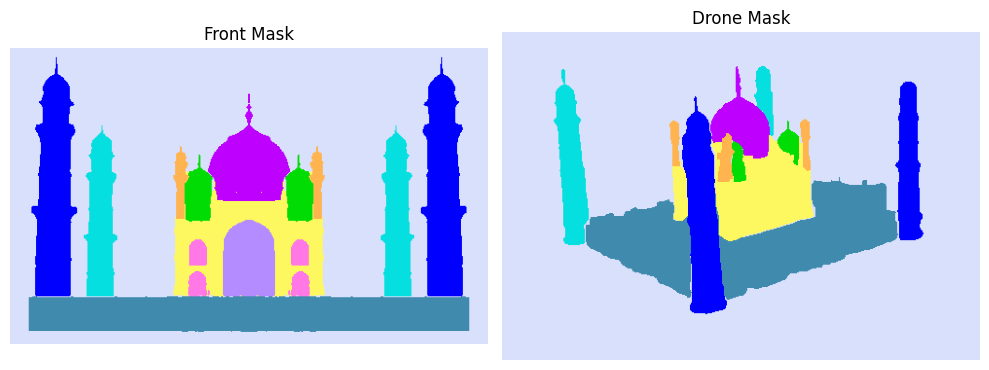

In [13]:
# --- Config ---
project_root = Path.cwd()
data_root    = project_root / "data"
RESULTS_SRC  = "results"   # or "results"
monuments = ["Akbar","Bibi","Charminar","Itimad","Taj"]

monument_name = monuments[1]

# --- Paths ---
mask_dir  = data_root / monument_name / "masks"
voxel_path = project_root / RESULTS_SRC / "1.Orthographic_Voxel_Carving" / f"{monument_name}_voxel_grid.npz"
cam_path   = project_root / RESULTS_SRC / "2.Perspective_Camera_Estimation"/ f"{monument_name}_camera_params.json"

# --- Load ---
voxel_grid = np.load(voxel_path)["voxel_grid"]
print("Voxel grid shape:", voxel_grid.shape)
print("Voxel:", voxel_path.resolve())
print("Camera:", cam_path.resolve())

# --- Load images with optional scaling ---
def load_mask(view, max_dim=None):
    path = os.path.join(mask_dir, f"{monument_name}_{view}_mask.png")
    img = Image.open(path)
    if max_dim:
        w, h = img.size
        scale = max_dim / max(w, h)
        img = img.resize((int(w * scale), int(h * scale)), Image.NEAREST)
    return np.array(img)

# Load images (specify scaling only if needed)
voxel_dim_max = np.max(voxel_grid.shape)
front_mask = load_mask("front", max_dim=voxel_dim_max)   # scaled
drone_mask = load_mask("drone")                # original size
# new_mask = load_mask(f"{view}")

print("Front mask shape:", front_mask.shape)
print("Drone mask shape:", drone_mask.shape)

plt.figure(figsize=(10, 5))
for i, (title, img) in enumerate([("Front", front_mask), ("Drone", drone_mask)]):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{title} Mask")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Load cameras

with open(cam_path, "r") as f:
    camera_results = json.load(f)


In [14]:
views = {
    "front": {
        "mask": front_mask,
        "labels": [part_colors['front_minarets'], part_colors['back_minarets']],
    },
    "drone": {
        "mask": drone_mask,
        "labels": [part_colors['front_minarets'], part_colors['back_minarets']],
    }
}


def to_numpy(obj):
    if isinstance(obj, list):
        return np.array(obj, dtype=np.float32)
    if isinstance(obj, dict):
        return {k: to_numpy(v) for k, v in obj.items()}
    return obj

camera_results = to_numpy(camera_results)


### 4. Deform

In [16]:
view = 'front' # 'drone' #'front'
voxel_padded = np.pad(voxel_grid, ((0, 0), (0, 0), (0, 0), (0, 0)), constant_values=0)

init_params_deform = {
 'chhatri': {'deform': {'scale_y': 1.0, 'shift_y': 0.0, 'scale_xz': 1.0, 'shift_xz': 0.0}, 'iou': 0.0},
 'windows': {'deform': {'scale_y': 1.0, 'shift_y': 0.0, 'scale_xz': 1.0, 'shift_xz': 0.0}, 'iou': 0.0},
 'mainbuilding': {'deform': {'scale_y': 1.0, 'shift_y': -1.0, 'scale_xz': 1.0, 'shift_xz': 0.0}, 'iou': 0.0}
}

deform_results, grid_store = launch_deform_viewer_fixed_camera(
    voxel_padded,
    part_colors,
    image=views[view]['mask'],
    cam_params=camera_results[view],
    part_names=list(part_colors.keys()),
    init_params=init_params_deform  # optional
)



In [17]:
deformed_grid = grid_store['grid']

Visualizing combined binary projection vs. binary ground-truth...


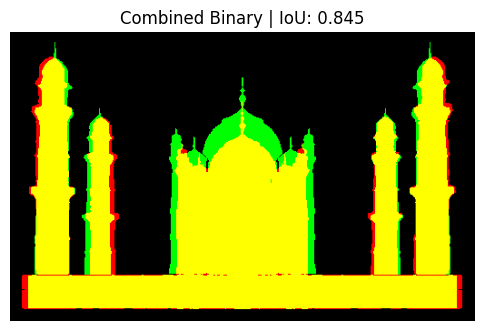

In [22]:
visualize_voxel_projection_iou(deformed_grid, part_colors, image=views[view]['mask'], cam_params=camera_results[view], mode='whole_on_whole')

### 5. Save deformed grid

In [24]:
RESULTS_SRC   = "results_temp"   # or "results"

# --- Path ---
save_path = (
    project_root
    / RESULTS_SRC
    / "3.Part-wise_3D_Refinement"
    / f"{monument_name}_deformed_voxel_grid.npz"
)

save_path.parent.mkdir(parents=True, exist_ok=True)

# --- Save ---
np.savez_compressed(save_path, voxel_grid=deformed_grid)

print("Deformed voxel grid saved to:", save_path.resolve())

Deformed voxel grid saved to: /home/sanju/mycode/O2P3D_final_paper/results_temp/3.Part-wise_3D_Refinement/Bibi_deformed_voxel_grid.npz
